1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

2. Random Forest - Feature Importance

In [7]:
# 2.1 Feature Importance Check with basic random forest model
#Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier
rf_1 = RandomForestClassifier(random_state=8,  max_features='sqrt')


rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [8]:
#Display feature importance
rf_1.feature_importances_

array([0.02478356, 0.02617264, 0.01763951, 0.01893946, 0.01608236,
       0.0190077 , 0.01720303, 0.02189497, 0.01951245, 0.01575297,
       0.01762793, 0.019705  , 0.01489463, 0.01840991, 0.07664613,
       0.04089644, 0.01753324, 0.10605748, 0.02073976, 0.01967763,
       0.01752607, 0.03115845, 0.06717638, 0.06068074, 0.04465404,
       0.02416698, 0.0534709 , 0.02310058, 0.0219594 , 0.02185477,
       0.02006312, 0.02571522, 0.03929657])

In [9]:
#Create a new dataframe "feat_imp_et_df" with the features importances and their name
feat_imp_et_df = pd.DataFrame(
    {
    'feature': X_train.columns,
     'feature_importance': rf_1.feature_importances_
     }
)

In [10]:
X_train.columns

Index(['GP', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per',
       'FT_per', 'twoP_per', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag',
       'adjoe', 'pfr', 'Rec_Rank', 'ast_tov', 'rim_ratio', 'mid_ratio',
       'adrtg', 'dporpag', 'stops', 'bpm', 'dbpm', 'gbpm', 'dgbpm', 'treb',
       'ast', 'stl', 'blk', 'pts'],
      dtype='object')

In [11]:
#Create a bar chart showing the features importance for the random tree model
alt.Chart(feat_imp_et_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)

3. Random Forest - Modelling

In [12]:
# Filter the features based on importance threshold
important_features = feat_imp_et_df[feat_imp_et_df['feature_importance'] >= 0.02]['feature']

# Filter the datasets to include only the important features
X_train_filtered = X_train[important_features]
X_val_filtered = X_val[important_features]
X_test_filtered = X_test[important_features]

In [13]:
#3.1 Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier
rf_3 = RandomForestClassifier(random_state=100,  max_features='sqrt', min_samples_split=50, max_depth = 15)


In [14]:
# 3.2 Train the model and save the predicted values
rf_3.fit(X_train_filtered, y_train)

# Select the probability for the positive class (class 1)
y_train_probs_rf3 = rf_3.predict_proba(X_train_filtered)[:, 1]
y_val_probs_rf3 = rf_3.predict_proba(X_val_filtered)[:, 1]

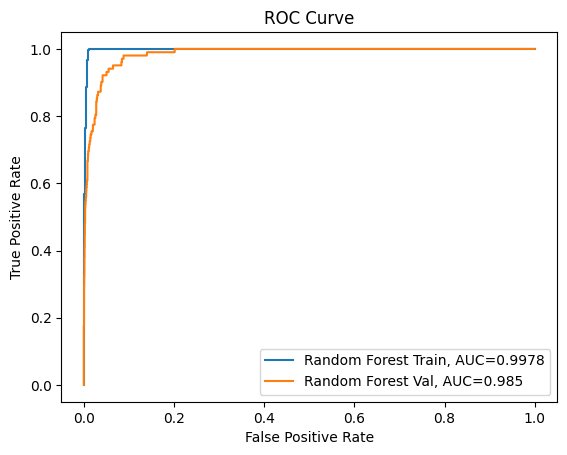

In [15]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric
from sklearn import metrics

# Set up plotting area
plt.figure(0).clf()

# Random Forest - Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_rf3)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_rf3), 4)
plt.plot(fpr, tpr, label="Random Forest Train, AUC="+str(auc))

# Random Forest - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_rf3)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_rf3), 4)
plt.plot(fpr, tpr, label="Random Forest Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [16]:
# 3.4 Save the probability of the test data
y_test_prob_rf3 = rf_3.predict_proba(X_test_filtered)

# Select the probability for the positive class (class 1)
y_test_prob_rf3 = y_test_prob_rf3[:, 1]


In [17]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_prob_df = pd.DataFrame(y_test_prob_rf3, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results_1 = pd.concat([player_id_test, y_test_prob_df], axis=1)

In [18]:
Results_1

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.000000
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.000000
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.001377
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.000000
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.000868
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.014948
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.000000
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.000000
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.000000


In [19]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results_1).to_csv('../data/external/smote_RandomForest_FE_Results.csv', index=False)

#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively randomForest.joblib 
dump(rf_3, '../models/randomForest.joblib')


['../models/randomForest.joblib']